# Description:

* Quick and dirty creation of a 16S rRNA tree of OTUs

# Setting variables

In [12]:
workDir = '/home/chantal/Chazy/Bulk/515_806/'
OTUFileDir = '/home/chantal/Chazy/data/ComboFastaFiles/'
OTUFile = 'otusn.pick.fasta'

taxFile = '/home/chantal/Chazy/data/ComboFastaFiles/otusn_tax/otusn_tax_assignments.txt'



nprocs = 24

In [14]:
%%R
physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'

# Init

In [2]:
import os
import numpy as np
from cogent.app.fasttree import build_tree_from_alignment
from cogent import DNA, LoadSeqs
from Bio import Entrez
Entrez.email = "chuck.peperanney@gmail.com"
from IPython.display import display, Image, SVG

In [5]:
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)

In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)
%cd $workDir    

/home/chantal/Chazy/Bulk/515_806


# Inference

In [7]:
!ln -f -s $OTUFileDir$OTUFile

In [8]:
!head -n 6 $OTUFile

>OTU.1
TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG
>OTU.2
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACAAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
>OTU.3
TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAAGCCCTGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG


In [9]:
!printf "Number of OTUs in fasta: "
!grep -c ">" $OTUFile

Number of OTUs in fasta: 25178


In [18]:
%%R 

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data()
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [19]:
%%R
#Subset to OTUs in 25% sparsity filtered dataset used for tillage and OM deseq2 w/o time

physeq.sparse = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)


physeq.sparse

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [80]:
%%R
otu_tab = otu_table(physeq.sparse)
OTUs_sparsity = as.data.frame((paste('>',rownames(otu_tab), sep = '')))

In [81]:
%%R
write.table(OTUs_sparsity, file = 'data/OTUs_0.25sparsity.txt', sep = '\t', col.names = FALSE, row.names = FALSE,
           quote = FALSE)

In [82]:
! head data/OTUs_0.25sparsity.txt

>OTU.1739
>OTU.1813
>OTU.778
>OTU.2180
>OTU.12365
>OTU.2343
>OTU.1158
>OTU.23337
>OTU.2630
>OTU.2206


In [83]:
! grep -c 'OTU' data/OTUs_0.25sparsity.txt

3964


In [84]:
!grep -f data/OTUs_0.25sparsity.txt -A 1 -x /home/chantal/Chazy/data/ComboFastaFiles/otusn.pick.fasta > data/sparse_alignment.fasta

In [86]:
! grep -c '>' data/sparse_alignment.fasta

3964


## Using SSU-Align to align seqs and masking based on alignment posterior probabilities.

In [87]:
!ssu-prep -f -x -b 50 --rfonly --dna data/sparse_alignment.fasta ssu_aln 20 

# ssu-prep :: prepare SSU rRNA sequences for parallel ssu-align jobs
# SSU-ALIGN 0.1 (June 2010)
# Copyright (C) 2010 HHMI Janelia Farm Research Campus
# Freely distributed under the GNU General Public License (GPLv3)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-prep -x -f -b 50 --dna --rfonly data/sparse_alignment.fasta ssu_aln 20
# date:    Wed Apr  6 08:22:39 2016
#
# Validating input sequence file ... done.
#
# Preparing 20 ssu-align jobs ...
# Partitioning seqs with goal of equalizing total number of nucleotides per job ...
#
# output file name          description                                          
# ------------------------  -----------------------------------------------------
  ssu_aln/sparse_alignment.fasta.1  partition  1 FASTA sequence file (199 seqs; 50401 nt)
  ssu_aln/sparse_alignment.fasta.2  partition  2 FASTA sequence file (199 seqs; 50409 nt)
  ssu_aln/sparse_alignment.fasta.3  partition  3 FASTA sequence file (199 s

In [88]:
!./ssu_aln.ssu-align.sh

# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.1 ssu_aln/ssu_aln.1 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.2 ssu_aln/ssu_aln.2 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.3 ssu_aln/ssu_aln.3 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.4 ssu_aln/ssu_aln.4 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.5 ssu_aln/ssu_aln.5 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.6 ssu_aln/ssu_aln.6 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.7 ssu_aln/ssu_aln.7 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.8 ssu_aln/ssu_aln.8 > /dev/null &
# Executing: ssu-align -b 50 --dna --rfonly ssu_aln/sparse_alignment.fasta.9 ssu_aln/ssu_aln.9 > /dev/null &
# Executing: ssu-al

In [89]:
!ssu-mask --dna --afa ssu_aln

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1 (June 2010)
# Copyright (C) 2010 HHMI Janelia Farm Research Campus
# Freely distributed under the GNU General Public License (GPLv3)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask --afa --dna ssu_aln
# date:    Wed Apr  6 08:23:14 2016
#
# Masking alignments based on posterior probabilities...
#
#                                                     mask    
#                                                 ------------
# file name                  in/out  type  #cols  incl.  excl.
# -------------------------  ------  ----  -----  -----  -----
  ssu_aln.bacteria.stk        input   aln   1582      -      -
  ssu_aln.bacteria.mask      output  mask   1582    248   1334
  ssu_aln.bacteria.mask.pdf  output   pdf   1582    248   1334
  ssu_aln.bacteria.mask.afa  output   aln    248      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#
# List of executed comman

In [90]:
!seq_tools fasta_unwrap ssu_aln/ssu_aln.bacteria.mask.afa | head

>OTU.1
TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG
>OTU.2
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACATTCAAAACTGACAAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
>OTU.3
TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAAGCCCTGGGCTCAACCTGGGAACATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
>OTU.4
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTCCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCAAGTGTAGCGGTGAAATGCGTAGAGATTTGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGACTGACACTGAGGCG

### Using Sulfolobus as the root (acc. X90478).

In [91]:
sso_acc = "X90478"
sso_fa = Entrez.efetch(db="nucleotide", id=sso_acc, rettype="fasta", retmode="text").readlines()

In [92]:
out = open(os.path.join(workDir, 'X90478.fasta'), 'w')
sso_fa_namestrip = sso_fa[1:]
sso_fa_namestrip.insert(0,">%s\n"%sso_acc)
out.writelines(sso_fa_namestrip)
out.close()

In [93]:
!head -n 4 X90478.fasta

>X90478
TCCTGCCGGTCCCGACCGCTATCGGGGTGGGGCTAAGCCATGGGAGTCGTACGCTCCCGGGCAAGGGAGC
GTGGCGGACGGCTGAGTAACACGTGGCTAACCTACCCTGAGGAGGGAGATAACCCCGGGAAACTGGGGAT
AATCTCCCATAGGCGAGGAGTCCTGGAACGGTTCCTCGCTGAAAGGCTCATGGGCTATTCCCCGCTCATG


### Align the outgroup to the same cm (use the same mask that was established earlier).

In [94]:
!ssu-align -f -n bacteria --dna --rfonly X90478.fasta sso_aln

# ssu-align :: align SSU rRNA sequences
# SSU-ALIGN 0.1 (June 2010)
# Copyright (C) 2010 HHMI Janelia Farm Research Campus
# Freely distributed under the GNU General Public License (GPLv3)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-align -f -n bacteria --dna --rfonly X90478.fasta sso_aln
# date:    Wed Apr  6 08:23:16 2016
#
# Validating input sequence file ... done.
#
# Stage 1: Determining SSU start/end positions and best-matching models...
#
# output file name          description                                
# ------------------------  -------------------------------------------
  sso_aln.tab               locations/scores of hits defined by HMM(s)
  sso_aln.bacteria.hitlist  list of sequences to align with bacteria CM
  sso_aln.bacteria.fa             1 sequence  to align with bacteria CM
#
# Stage 2: Aligning each sequence to its best-matching model...
#
# output file name          description
# ------------------------  ----------

In [95]:
!ssu-mask -s ssu_aln/ssu_aln.bacteria.mask --dna --afa sso_aln/

# ssu-mask :: mask SSU rRNA alignments
# SSU-ALIGN 0.1 (June 2010)
# Copyright (C) 2010 HHMI Janelia Farm Research Campus
# Freely distributed under the GNU General Public License (GPLv3)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# command: ssu-mask -s ssu_aln/ssu_aln.bacteria.mask --afa --dna sso_aln/
# date:    Wed Apr  6 08:23:17 2016
#
# Masking alignments using pre-existing masks...
#
#                                                     mask    
#                                                 ------------
# file name                  in/out  type  #cols  incl.  excl.
# -------------------------  ------  ----  -----  -----  -----
  sso_aln.bacteria.stk        input   aln   1582      -      -
  ssu_aln.bacteria.mask       input  mask   1582    248   1334
  sso_aln.bacteria.mask.pdf  output   pdf   1582    248   1334
  sso_aln.bacteria.mask.afa  output   aln    248      -      -
#
# All attempts to draw structure diagrams of masks were successful.
#

In [96]:
!seq_tools fasta_unwrap sso_aln/sso_aln.bacteria.mask.afa | head

>X90478
TACCAGCCCCGCGAG---TGGTCGGGATTACTGGGCCTAAAGCGCCCGTAGCCGGCCCGACAAGTCACTCCTTAAAGACCCCGGCTCAACCGGGGGAAGGGTGATACTGTCGGGCTAGGGGGCGGGAGAGGCCAGCGGTACTCCCGGAGTAGGGGCGAAATCCTCAGATCTCGGGAGGACCACCAGTGGCGAAAGCGGCTGGCTAGAACGCCCGACGGTGAGGGGCGAAAGCCGGGGCAGCAAAAGGG

In [97]:
!cat sso_aln/sso_aln.bacteria.mask.afa ssu_aln/ssu_aln.bacteria.mask.afa > aln_for_tree.fasta

In [98]:
!seq_tools fasta_unwrap aln_for_tree.fasta | head

>X90478
TACCAGCCCCGCGAG---TGGTCGGGATTACTGGGCCTAAAGCGCCCGTAGCCGGCCCGACAAGTCACTCCTTAAAGACCCCGGCTCAACCGGGGGAAGGGTGATACTGTCGGGCTAGGGGGCGGGAGAGGCCAGCGGTACTCCCGGAGTAGGGGCGAAATCCTCAGATCTCGGGAGGACCACCAGTGGCGAAAGCGGCTGGCTAGAACGCCCGACGGTGAGGGGCGAAAGCCGGGGCAGCAAAAGGG
>OTU.1
TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG
>OTU.2
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACATTCAAAACTGACAAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
>OTU.3
TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAAGCCCTGGGCTCAACCTGGGAACATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGACTGACACTGAGGT

## Inferring and rooting the tree

* 1000 'bootstrap' replicates (default)

In [101]:
aln = LoadSeqs(os.path.join(workDir, 'aln_for_tree.fasta'), moltype=DNA)
t_unroot = build_tree_from_alignment(aln, moltype=DNA)

In [102]:
t_rooted = t_unroot.rootedWithTip(sso_acc)

In [103]:
t_rooted.writeToFile(os.path.join(workDir, 'otusn_pick_sparse.tree'))

## Formatting the tree

In [106]:
# ladderize tree
! /home/chantal/tree_edit/bin/ladderize.r -t otusn_pick_sparse.tree

## Viewing the tree

In [107]:
!nw_display -i 'visibility:hidden' -l 'visibility:hidden' -b 'opacity:0' \
    -S -s -r otusn_pick_sparse_lad.nwk > otusn_pick_sparse_lad_nwk.svg

In [108]:
treePic = os.path.join(workDir, 'otusn_pick_sparse_lad_nwk.svg')
SVG(filename=treePic)

# tree summary

In [109]:
!printf "Number of tree tips: "
!nw_labels -I otusn_pick_sparse_lad.nwk | wc -l

Number of tree tips: 3965


# Making 'bootstrap' trees

* FastTree doesn't write out each bootstrap tree, just bootstrap values on the final tree
* Need the bootstrap trees for concenTRAIT 
* Making the bootstrap trees 'manually' by bootstrapping the alignment and writting the trees

In [111]:
alnFile = os.path.join(workDir, 'aln_for_tree.fasta')
bootFile = os.path.splitext(alnFile)[0] + '_sparse_boot.nwk'
!/home/chantal/tree_edit/bin/FastTree_bootTrees.py -p 20 $alnFile > $bootFile

Inferring bootstrap tree: 1
Inferring bootstrap tree: 3
Inferring bootstrap tree: 5
Inferring bootstrap tree: 7
Inferring bootstrap tree: 9
Inferring bootstrap tree: 11
Inferring bootstrap tree: 13
Inferring bootstrap tree: 15
Inferring bootstrap tree: 17
Inferring bootstrap tree: 19
Inferring bootstrap tree: 21
Inferring bootstrap tree: 23
Inferring bootstrap tree: 25
Inferring bootstrap tree: 27
Inferring bootstrap tree: 29
Inferring bootstrap tree: 31
Inferring bootstrap tree: 33
Inferring bootstrap tree: 35
Inferring bootstrap tree: 37
Inferring bootstrap tree: 39
Inferring bootstrap tree: 4
Inferring bootstrap tree: 24
Inferring bootstrap tree: 36
Inferring bootstrap tree: 6
Inferring bootstrap tree: 2
Inferring bootstrap tree: 16
Inferring bootstrap tree: 32
Inferring bootstrap tree: 22
Inferring bootstrap tree: 18
Inferring bootstrap tree: 12
Inferring bootstrap tree: 14
Inferring bootstrap tree: 10
Inferring bootstrap tree: 30
Inferring bootstrap tree: 8
Inferring bootstrap tre

In [112]:
!wc -l $bootFile

100 /home/chantal/Chazy/Bulk/515_806/aln_for_tree_sparse_boot.nwk


# Assessing monophyly of taxonomic groups

* How well does the tree place each taxonomic grouping into a monophyletic clade?
* Using MonoPhy R package (https://cran.r-project.org/web/packages/MonoPhy/index.html)

### formatting taxonomy file

* Some taxonomic levels are not present for certain taxa 

In [68]:
import re
regex = re.compile(' __')

outFile = os.path.splitext(taxFile)[0] + '_e.txt'

tax_levels = ('Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species',)
nNeedLevels = len(tax_levels)


with open(taxFile, 'rb') as inFH, open(outFile, 'wb') as oFH:
    for line in inFH:
        line = line.rstrip().split('\t')
        line[1] = re.sub(regex, '', line[1])
        line = line[:2]
        tax = line[1].split(';')
        nLevels = len(tax)
        nMoreLevels = nNeedLevels - nLevels
        if nMoreLevels > 0:
            tax = tax + ['unclassified'] * nMoreLevels
        line = line[:1] + tax
        oFH.write('\t'.join(line) + '\n')
        
taxFile_edit = outFile
print 'File written: {}'.format(taxFile_edit)

File written: /var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/OTU_binning/otusn_tax/otusn_tax_assignments_e.txt


### Calling MonoPhy

In [107]:
!tree_edit monophyly otusn_pick_lad.nwk $taxFile_edit -o otusn_pick_lad_monophy -r X90478

File saved to: otusn_pick_lad_monophy 


In [108]:
%pushnote fasttree default monphyly done

# Inference using gtr distances

In [ ]:
# calling fasttree
!FastTree -nt -gtr < aln_for_tree.fasta > otusn_pick_gtr.nwk
!tree_edit ladderize -t otusn_pick_gtr.nwk

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
FastTree Version 2.1.3 SSE3
Alignment: standard input
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Generalized Time-Reversible, CAT approximation with 20 rate categories
Initial topology in 28.64 seconds
Refining topology: 54 rounds ME-NNIs, 2 rounds ME-SPRs, 27 rounds ML-NNIs
**OUTPUT MUTED**

In [ ]:
!tree_edit monophyly otusn_pick_gtr_lad.nwk $taxFile_edit -o otusn_pick_gtr_lad_monophy -r X90478

## Loading & plotting results

In [113]:
%%R
get_monophy_summary = function(inFile){
    monophy.res = readRDS(inFile)
    monophy.sum = GetSummaryMonophyly(monophy.res)
    df = do.call(rbind, monophy.sum)
    df$tax_level = gsub('Taxlevel_|\\..+', '', rownames(df))
    df$variable = gsub('.+\\.', '', rownames(df))
    df = df %>%
        mutate(Taxa = Taxa %>% as.character %>% as.numeric,
               Tips = Tips %>% as.character %>% as.numeric)
    return(df)
}

In [114]:
%%R -i workDir

# FastTree default
inFile = file.path(workDir, 'otusn_pick_lad_monophy')
df.std = get_monophy_summary(inFile) %>%
    mutate(params = 'default')

# FastTree w/ gtr
inFile = file.path(workDir, 'otusn_pick_gtr_lad_monophy')
df.gtr = get_monophy_summary(inFile) %>%
    mutate(params = 'gtr')


In [116]:
%%R
# joining
df.j = rbind(df.std, df.gtr) 
df.j %>% head(n=5)

  Taxa  Tips tax_level         variable  params
1    2 12602         1            Total default
2    1 12601         1     Monophyletic default
3   NA     0         1 Non-Monophyletic default
4    1     1         1        Monotypic default
5    0     0         1         Intruder default


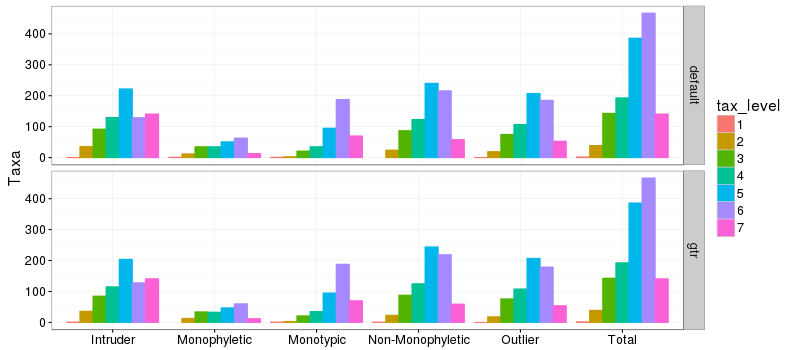

In [117]:
%%R -w 800 -h 350
# plotting
p1 = ggplot(df.j, aes(variable, Taxa, color=tax_level, fill=tax_level)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(params ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )
p1

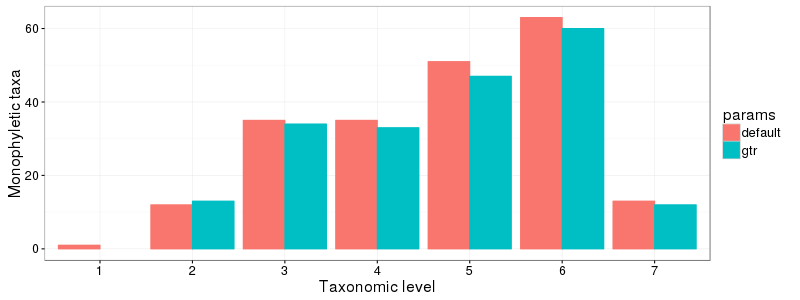

In [127]:
%%R -w 800 -h 300

df.j.f = df.j %>%
    filter(variable == 'Monophyletic')

# plotting
p1 = ggplot(df.j.f, aes(tax_level, Taxa, color=params, fill=params)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Taxonomic level', y='Monophyletic taxa') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p1

#### Notes

* It appears that the default parameters actually create a more taxonomically accurate phylogeny.